# **Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
import xgboost as xgb
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score,f1_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from lightgbm import LGBMClassifier

import warnings

warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'category_encoders'

# **Let’s Start**


As you can see, after I loaded the dataset, I removed both the “Passenger Id” and “Name” columns. They are not going to provide any useful or important information to the prediction. Someone’s name or Id does not change the probability of being Transported.

In [2]:
df = pd.read_csv("data/train.csv")
#After loading the dataset, I dropped the "PassengerId" and the "Name" column.

#But why? Knowing a passengers name or Id will not provide any usefull information to the model.

#Someone named "James" or with a certain Id number will not have a greater or lower chance of surviving.

#So, I just removed both columns.

df.drop(columns=["PassengerId","Name"],inplace=True)

Now, we are going to discuss a fundamental step I came across after trying to improve my score a thousand times. This step relies on exploring the “Cabin” column. Notice that the rows on the “Cabin” column follow a specific pattern. Something like this: “A/5/S”, “C/1/S”, “F/7/P”. And I decided to investigate it. So, to make things simple I split the rows of the “Cabin” into three columns based on both slashes (”/”) of the rows. For example, the “A/5/S” row would be transformed into three new columns: The first one is named “cabin_code” referring to the character behind the first slash (A). The second one named “id_cabin” refers to the character behind the second slash (5). The third one named “cabin_sector” refers to the character after the second slash (S). And we end up with three new columns.

In [3]:
#Splitting

df[["cabin_code","id_cabin","cabin_sector"]] = df["Cabin"].str.split("/", n=2, expand=True)

df.head(4)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_code,id_cabin,cabin_sector
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S


First of all, I noticed that “cabin_code” only has 8 different characters which means that the cabins are, somehow, divided into 8 sections.

In [4]:
cabinss = df.cabin_code.value_counts(1).sort_index()
cabinss

cabin_code
A    0.030139
B    0.091712
C    0.087944
D    0.056275
E    0.103132
F    0.328938
G    0.301271
T    0.000589
Name: proportion, dtype: float64

Also, I asked myself if passengers from a specific section had a higher chance of being transported or if this statement was not true. With the plot below we can conclude that passengers from the B and C sections have a greater chance of surviving and passengers from the E section have a lower chance of surviving.

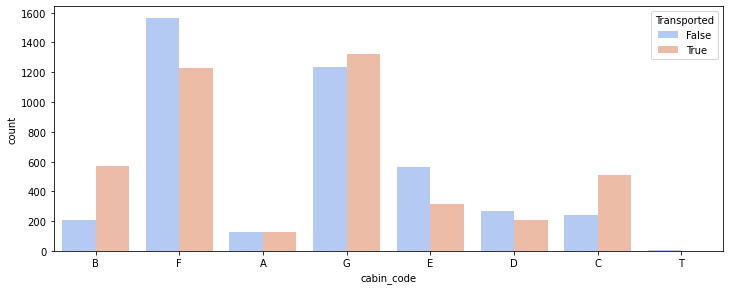

In [5]:
plt.figure(figsize=(12, 4.5))
_= sns.countplot(data=df, x="cabin_code", hue="Transported", palette="coolwarm")

I did the same thing with the “cabin_sector” column and also noticed that there was a difference between the sectors. Passengers from the P sector have a lower chance of being transported, while in the S sector, the opposite happens.

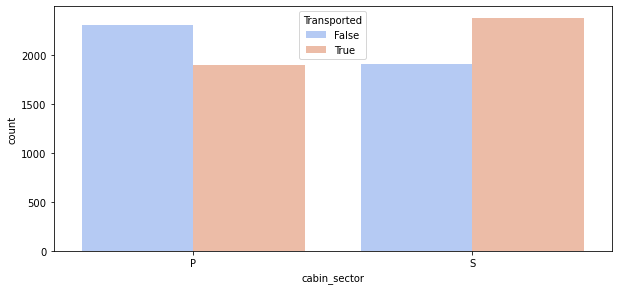

In [6]:
plt.figure(figsize=(10, 4.5))
_= sns.countplot(data=df, x="cabin_sector", hue="Transported", palette="coolwarm")

This means that this exploration of the original “Cabin” column is worth it since new insights are being added to the model.

Now, we can finally delete the “Cabin” column. It will not provide any useful information for the model anymore. We have already extracted everything useful from it.

I also removed the “cabin_id” and the column that I had created. As I said before, the Id will not interfere with the model’s predictive ability.

So used: df.drop(columns=[“Cabin”,”id_cabin”], inplace=True) to drop both columns

Before splitting our data, the “Transported” column must be in a binary format. As you can see, I switched “True” for 1 and “False” for 0.

Binary transformation: df[“Transported”] = df[“Transported”].map({True:1, False:0})

I also removed every row that had missing values in the “cabin_code” column.

In [7]:
pop_id_cabin = df.pop("id_cabin")
df.insert(3, 'id_cabin', pop_id_cabin)  # Insert column 'C' at the beginning

pop_id_cabin = df.pop("cabin_sector")
df.insert(3, 'cabin_sector', pop_id_cabin)  # Insert column 'C' at the beg

pop_id_cabin = df.pop("cabin_code")
df.insert(3, 'cabin_code', pop_id_cabin)  # Insert column 'C' at the beg

In [8]:

#BINARY TRANSFORMATION
df["Transported"] = df["Transported"].map({True:1, False:0})


#DROPPING COLUMNS
df.drop(columns=["Cabin","id_cabin"], inplace=True)


#DROPPING NULLS
df.dropna(subset=["cabin_code"], inplace=True)


Now, we can finally split the data and proceed to develop our model.

After splitting in train and test, I separated the test data into two categories: numerical and categorical. Why is that? We are going to perform different operations depending on the type of the variable. Categorical data must be encoded since most models are not able to understand categorical values and it must be converted to numerical values. Also, we are going to apply different techniques to fill the null values in our dataset, but I will talk more about it later on.

# **Splitting Data**

In [9]:
#Define X and y

X = df.iloc[:,0:12]
y = df["Transported"]

In [10]:
#Data splitting

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.25)

In [11]:
#Separate categorical and numerical

cat_feat = np.array([coluna for coluna in X_train.columns if X_train[coluna].dtype.name == 'object'])

num_feat = np.array([coluna for coluna in X_train.columns if coluna not in cat_feat])

We can now create our pipeline. There are going to be two pipelines: one is going to handle the categorical data and the other one is going to handle numerical data. The missing values of the categorical data will be filled with the most frequent value (mode) and after the Target Encoder will be applied to transform categorical variables into numerical variables. The numerical data missing values will be filled with a strategy called K-nearest neighbors, which uses the Euclidean distance between the data points to find the best number to fill the missing values. If don’t know how this Pipeline technique works, I recommend you check my article about Pipelines. ("https://medium.com/@fernandao.lacerda.dantas/boost-your-pipelines-with-columntransformer-b2c009db096f")

In [12]:
#Categorical and numerical pipelines


cat_pipe = Pipeline([("imputer_cat", SimpleImputer(strategy="most_frequent")),("encoder", ce.TargetEncoder()),
                    ])

num_pipe = Pipeline([("imputer_num", KNNImputer(n_neighbors=3))])


And with column transformer, we can attach both transformations to one variable that I named “transformer”. Observe that we also have to specify the type of data to which the pipeline will be applied to: “cat_pipe” will be applied to “cat_feat” and “num_pipe” will be applied to “num_feat”, meaning the categorical pipeline will take care of the categorical data and the numerical pipeline will take care of the numerical data.

In [13]:
#Using ColumnTransformer 


transformer = ColumnTransformer([("num_trans", num_pipe, num_feat),
                            ("cat_trans", cat_pipe, cat_feat)])



After finishing the pipelines, we have to apply the transformations to our data. We use “fit.transform” in the “X_train” data to make the model “learn” the transformations and apply “transform” in the “X_test” data.

In [14]:
# ".fit_transform" in train data"

# ".transform" in test data"

X_train_transformed = transformer.fit_transform(X_train, y_train)
X_test_transformed = transformer.transform(X_test)


In the next step, we are going to perform a Stratified Cross-Validation to select the best tree-based model we will use. We are going to try three models: LGBMClassifier, XGBoost and XGBoost (booster=”gblinear”). And based on the accuracy, the cross-validation will give the mean and the standard deviation of the performance of each model.

# **Cross Validation**

In [15]:
models = []

models.append(("xgb",xgb.XGBClassifier()))
models.append(("xgbgblinear",xgb.XGBClassifier(booster="gblinear")))
models.append(("LGBM",LGBMClassifier(verbose=-1)))


print(models)

results = dict()

for  name, model in models:
    skf = StratifiedKFold(n_splits = 5, random_state=None)
    cv_results = cross_val_score(model,X_train_transformed,y_train,cv=skf, scoring="accuracy")
    results[name]= (cv_results.mean(), cv_results.std())

print("name     results.mean     results.std")

for key,value in results.items():
    print(key,value)

[('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)), ('xgbgblinear', XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categor

  File "c:\ProgramData\Anaconda3\envs\DL\lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\ProgramData\Anaconda3\envs\DL\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\ProgramData\Anaconda3\envs\DL\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\Anaconda3\envs\DL\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


name     results.mean     results.std
xgb (0.7910518053375195, 0.007132066996295497)
xgbgblinear (0.6076923076923076, 0.13958718993205685)
LGBM (0.7960753532182104, 0.005903169757288259)


We can see that LGBMClassifier had the best performance, therefore it will be the model used.

In [16]:
lgbmc = LGBMClassifier()


However, the model itself will not be enough to provide great accuracy. Thus, we now have to perform what is called hyperparameter tuning to make the model more precise.

We set the parameters we want to test and using sklearn’s GridSearchCV we will obtain the best hyperparameters. GridSearchCV will test the parameters that we want and will show us the combination that has the best performance.

# **Hyperparameter Tunning**

In [1]:


lgbm_params = {"n_estimators":[100,200,300], 
               "learning_rate":[0.01,0.05,0.1,0.3],
               "num_leaves":[20,50,80,100],
              "verbose":[-1]}



In [18]:
grid_search = GridSearchCV (estimator = lgbmc,
                            param_grid = lgbm_params,
                            n_jobs=-1,
                            cv = 5,
                            scoring="accuracy",
                           error_score='raise')
                        

In [19]:
grid_result = grid_search.fit(X_train_transformed, y_train)


final_model = lgbmc.set_params(**grid_result.best_params_)


With the best model optimized, we can finally train our model and obtain our predictions.

In [20]:

#training the model
final_model.fit(X_train_transformed, y_train)


#predictions
y_pred = final_model.predict(X_test_transformed)


After obtaining our predictions, we have to test our model using metrics such as recall, precision, f1 score and accuracy. The data frame below shows us some of those metrics and we can conclude that the model is having a great performance.

# **Scores**

In [21]:
precision = precision_score(y_pred, y_test)
accuracy = accuracy_score(y_pred, y_test)
recall = precision_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

score = []
score.append(("precision", precision))
score.append(("accuracy",accuracy))
score.append(("recall",recall))
score.append(("f1",f1))

score= pd.DataFrame(score)
score.rename(columns={0: "Metric", 1:"Result"}, inplace=True)

In [22]:
#Metrics obtained

display(score)

,Metric,Result
0,precision,0.846958
1,accuracy,0.811205
2,recall,0.846958
3,f1,0.816308


In [23]:
print(f"Precision: {score.iloc[0,1]:.4f}")
print(f"Accuracy: {score.iloc[1,1]:.4f}")
print(f"F1_Score: {score.iloc[2,1]:.4f}")
print(f"Recall: {score.iloc[3,1]:.4f}")

Precision: 0.8470
Accuracy: 0.8112
F1_Score: 0.8470
Recall: 0.8163


- Precision: 0.8470
- Accuracy: 0.8112
- F1_Score: 0.8470
- Recall: 0.8163

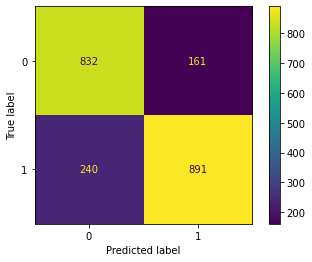

In [24]:
confusions_matrix = confusion_matrix(y_pred, y_test)

from sklearn.metrics import ConfusionMatrixDisplay

conf_disp = ConfusionMatrixDisplay(confusion_matrix=confusions_matrix)

conf_disp.plot()

# **Submission**

In [25]:
testecsv = pd.read_csv("data/test.csv")

In [26]:
testecsv.head(6)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
5,0027_01,Earth,False,F/7/P,TRAPPIST-1e,31.0,False,0.0,1615.0,263.0,113.0,60.0,Karlen Ricks


In [27]:
testecsv[["cabin_code","id_cabin","cabin_sector"]] = testecsv["Cabin"].str.split("/", n=2, expand=True)

In [28]:
testecsv.drop(columns=["id_cabin"], inplace=True)

In [29]:
X_teste = testecsv.drop(columns=["PassengerId","Cabin","Name"])


In [30]:
testecsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
 13  cabin_code    4177 non-null   object 
 14  cabin_sector  4177 non-null   object 
dtypes: float64(6), object(9)
memory usage: 501.3+ KB


In [31]:
model = final_model

In [32]:
X.dropna(subset=["cabin_code"], inplace=True)

In [33]:
X = transformer.fit_transform(X,y)
X_teste = transformer.transform(X_teste)

In [34]:
model.fit(X, y)

LGBMClassifier(learning_rate=0.05, num_leaves=20, verbose=-1)

In [35]:
y_predz = model.predict(X_teste)

In [36]:
subimisspace = pd.Series(index = testecsv["PassengerId"].values, data = y_predz)

In [37]:
subimisspace = subimisspace.reset_index()

In [38]:
subimisspace = pd.DataFrame(subimisspace)
subimisspace

,index,0
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
...,...,...
4272,9266_02,1
4273,9269_01,1
4274,9271_01,1
4275,9273_01,0


In [39]:
subimisspace[0]=subimisspace[0].map({1:"True", 0:"False"})


In [40]:
subimisspace.rename(columns = {"index":"PassengerId", 0:"Transported"}, inplace=True)

In [41]:
subimisspace.to_csv("testy.csv", index=False)

In [42]:
subimisspace

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,False


The strategies that I mention in this article led me to a 0.80664 score in the competition and I am sure you can improve my model to achieve an even higher score with your knowledge!

If you enjoyed this article, don’t forget to support me or hit me with a follow!

See you in the next article!

-Fernando Dantas 